In [27]:
#підключаємо бібліотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
#завантажуємо файли
df_raw = pd.read_csv("insufficient_activity.csv")



In [29]:
df_raw.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,IsLatestYear,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,Dim3 type,Dim3,Dim3ValueCode,DataSourceDimValueCode,DataSource,FactValueNumericPrefix,FactValueNumeric,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,NCD_PAA,Prevalence of insufficient physical activity a...,text,AFR,Africa,Country,RWA,Rwanda,Year,2022,True,Sex,Female,SEX_FMLE,Age Group,18+ years,AGEGROUP_YEARS18-PLUS,NaN,NaN,NaN,NaN,NaN,NaN,10.07,NaN,NaN,5.16,NaN,17.09,10.1 [5.2-17.1],NaN,NaN,EN,2024-06-20T21:00:00.000Z
1,NCD_PAA,Prevalence of insufficient physical activity a...,text,SEAR,South-East Asia,Country,NPL,Nepal,Year,2022,True,Sex,Male,SEX_MLE,Age Group,18+ years,AGEGROUP_YEARS18-PLUS,NaN,NaN,NaN,NaN,NaN,NaN,10.45,NaN,NaN,5.15,NaN,17.74,10.4 [5.1-17.7],NaN,NaN,EN,2024-06-20T21:00:00.000Z
2,NCD_PAA,Prevalence of insufficient physical activity a...,text,AFR,Africa,Country,COM,Comoros,Year,2022,True,Sex,Male,SEX_MLE,Age Group,18+ years,AGEGROUP_YEARS18-PLUS,NaN,NaN,NaN,NaN,NaN,NaN,10.54,NaN,NaN,3.13,NaN,24.20,10.5 [3.1-24.2],NaN,NaN,EN,2024-06-20T21:00:00.000Z
3,NCD_PAA,Prevalence of insufficient physical activity a...,text,EUR,Europe,Country,NLD,Netherlands (Kingdom of the),Year,2022,True,Sex,Female,SEX_FMLE,Age Group,18+ years,AGEGROUP_YEARS18-PLUS,NaN,NaN,NaN,NaN,NaN,NaN,10.71,NaN,NaN,6.66,NaN,15.73,10.7 [6.7-15.7],NaN,NaN,EN,2024-06-20T21:00:00.000Z
4,NCD_PAA,Prevalence of insufficient physical activity a...,text,EUR,Europe,Country,TKM,Turkmenistan,Year,2022,True,Sex,Male,SEX_MLE,Age Group,18+ years,AGEGROUP_YEARS18-PLUS,NaN,NaN,NaN,NaN,NaN,NaN,10.82,NaN,NaN,4.53,NaN,19.54,10.8 [4.5-19.5],NaN,NaN,EN,2024-06-20T21:00:00.000Z


In [30]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13455 entries, 0 to 13454
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               13455 non-null  object 
 1   Indicator                   13455 non-null  object 
 2   ValueType                   13455 non-null  object 
 3   ParentLocationCode          13455 non-null  object 
 4   ParentLocation              13455 non-null  object 
 5   Location type               13455 non-null  object 
 6   SpatialDimValueCode         13455 non-null  object 
 7   Location                    13455 non-null  object 
 8   Period type                 13455 non-null  object 
 9   Period                      13455 non-null  int64  
 10  IsLatestYear                13455 non-null  bool   
 11  Dim1 type                   13455 non-null  object 
 12  Dim1                        13455 non-null  object 
 13  Dim1ValueCode               134

<Axes: >

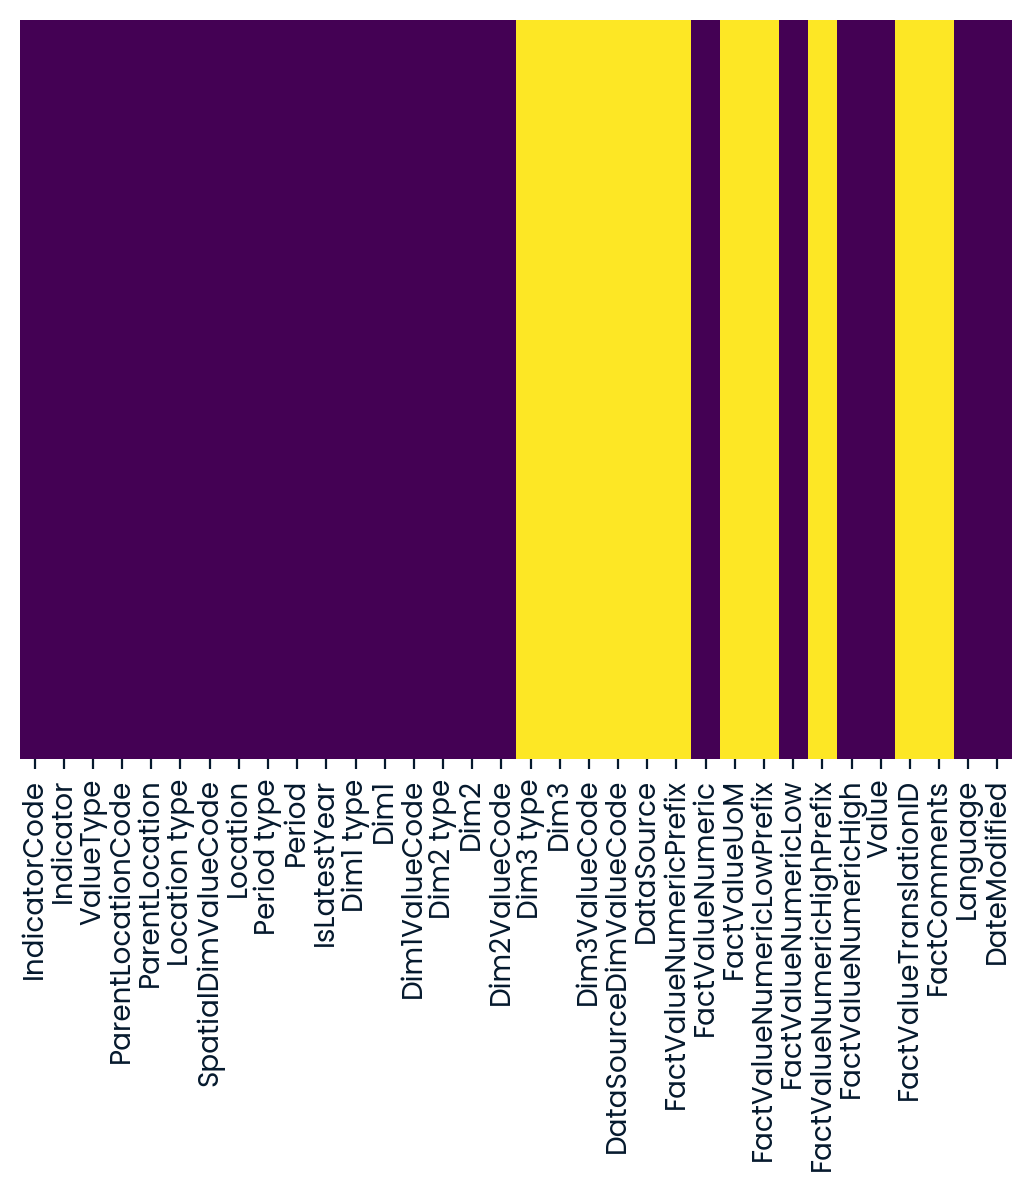

In [31]:
sns.heatmap(df_raw.isnull(), yticklabels=False, cbar=False, cmap='viridis')

**Що показує графік:**

- Жовті лінії = пропущені значення
- Фіолетовий = наявні дані
  
**Колонки** Dim3 type, Dim3, DataSourceDimValueCode,DataSource, DataSource, FactValueNumericPrefix,FactValueUoM,FactValueNumericLowPrefix,FactValueTranslationID,FactComments не містять значень
Висновок: колонки з пропущенними даними не є статистично важливими, тому видалимо їх перед моделюванням.

In [32]:
#беремо один рік
YEAR = 2019
#Фільтруємо:потрібний рік,тільки Both sexes,тільки ключові колонки
df = (
    df_raw[
        (df_raw["Period"] == YEAR) &
        (df_raw["Dim1"] == "Both sexes")
    ]
    .loc[:, ["Location", "FactValueNumeric"]]
    .rename(columns={
        "Location": "country",
        "FactValueNumeric": "insufficient_activity"
    })
)


In [33]:
df.shape


(195, 2)

In [34]:
df.head()

,country,insufficient_activity
1755,Bhutan,9.95
1760,Netherlands (Kingdom of the),10.52
1761,Sweden,10.58
1766,Finland,11.21
1768,Republic of Moldova,11.29


In [35]:
df.isna().sum()
df = df.dropna(subset=["insufficient_activity"])



In [36]:
df["insufficient_activity"].describe()


count    195.000000
mean      26.899641
std       12.118576
min        3.450000
25%       17.640000
50%       25.690000
75%       34.575000
max       63.920000
Name: insufficient_activity, dtype: float64

**Описова статистика** показує, що середній рівень недостатньої фізичної активності серед дорослого населення у світі становить близько 27%. 
Водночас спостерігається значна варіативність між країнами: у деяких країнах лише близько 4% населення є фізично неактивними, тоді як в інших цей показник перевищує 60%. 
Це свідчить про суттєві глобальні відмінності у фізичній активності, ймовірно зумовлені соціальними, культурними та економічними факторами.

In [41]:
#Як рівень фізичної активності відрізняється між регіонами?
# Фільтр: 2019 рік, Both sexes
df_region = (
    df_raw[
        (df_raw["Period"] == 2019) &
        (df_raw["Dim1"] == "Both sexes")
    ]
    .groupby("ParentLocation")["FactValueNumeric"]
    .mean()
    .reset_index()
    .rename(columns={
        "ParentLocation": "region",
        "FactValueNumeric": "avg_insufficient_activity"
    })
)

df_region


,region,avg_insufficient_activity
0,Africa,18.013830
1,Americas,36.397222
2,Eastern Mediterranean,38.423636
3,Europe,24.722308
4,South-East Asia,24.214000
5,Western Pacific,25.552143


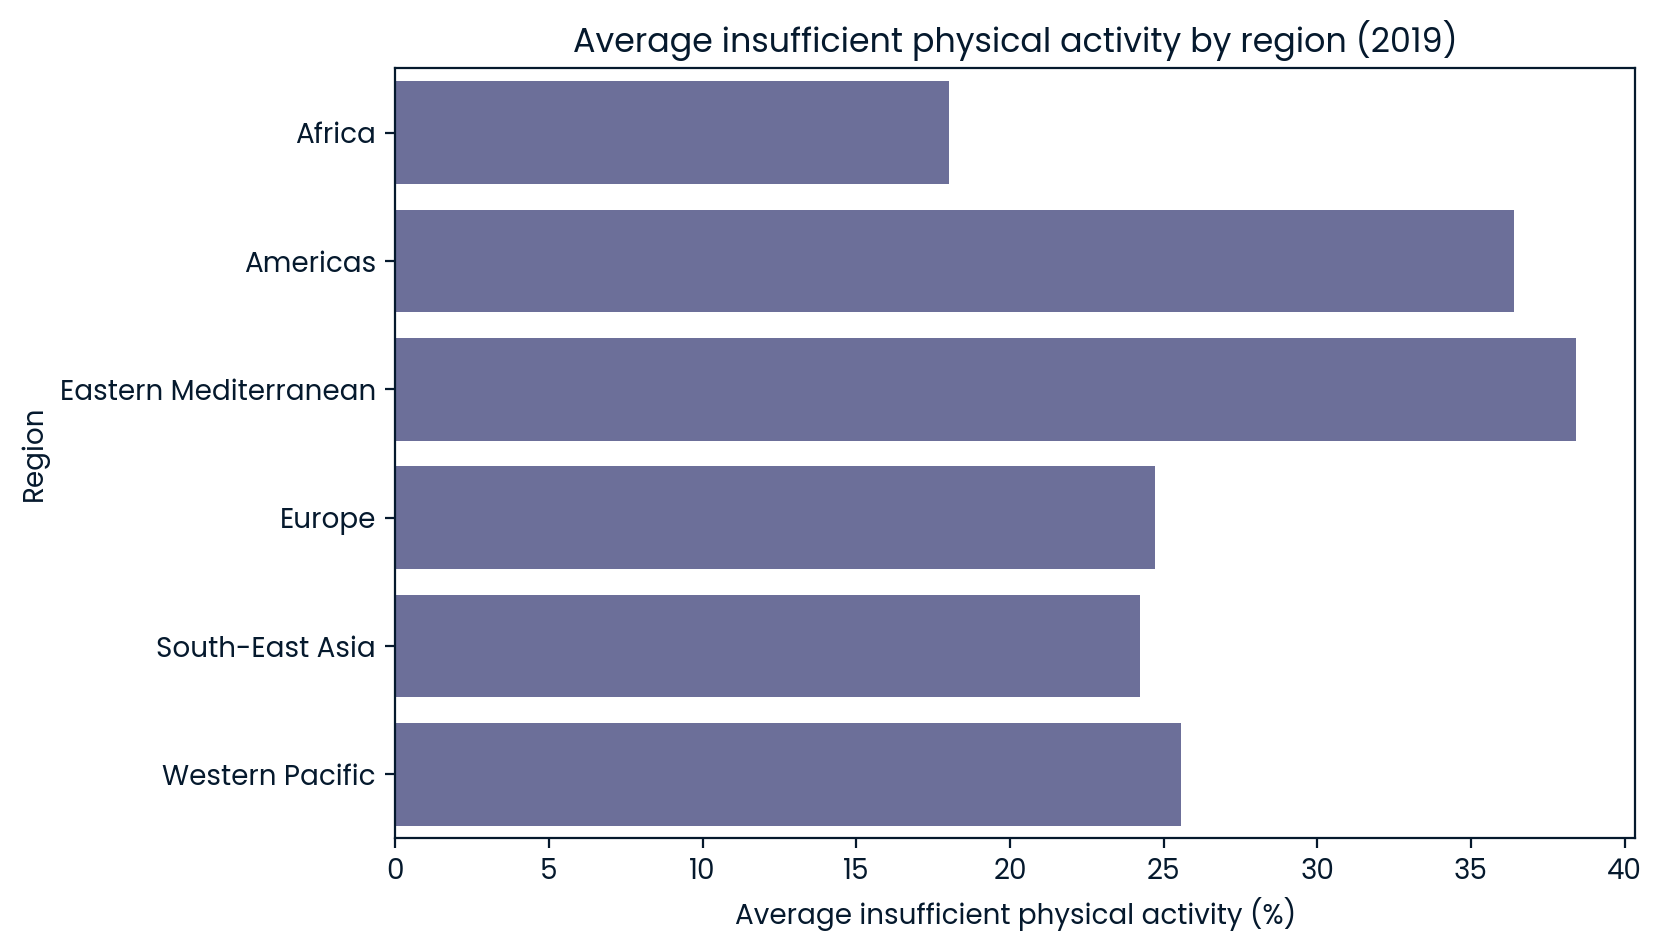

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_region,
    x="avg_insufficient_activity",
    y="region"
)
plt.xlabel("Average insufficient physical activity (%)")
plt.ylabel("Region")
plt.title("Average insufficient physical activity by region (2019)")
plt.show()


Аналіз регіональних відмінностей показав, що рівень фізичної активності суттєво відрізняється між регіонами світу. Найвищий рівень недостатньої фізичної активності спостерігається в більш урбанізованих регіонах, тоді як у деяких регіонах з переважно активним способом життя цей показник є значно нижчим.

In [43]:
df_gender = (
    df_raw[
        (df_raw["Period"] == 2019) &
        (df_raw["Dim1"].isin(["Male", "Female"]))
    ]
    .groupby("Dim1")["FactValueNumeric"]
    .mean()
    .reset_index()
    .rename(columns={
        "Dim1": "gender",
        "FactValueNumeric": "avg_insufficient_activity"
    })
)

df_gender


,gender,avg_insufficient_activity
0,Female,30.567026
1,Male,23.187231


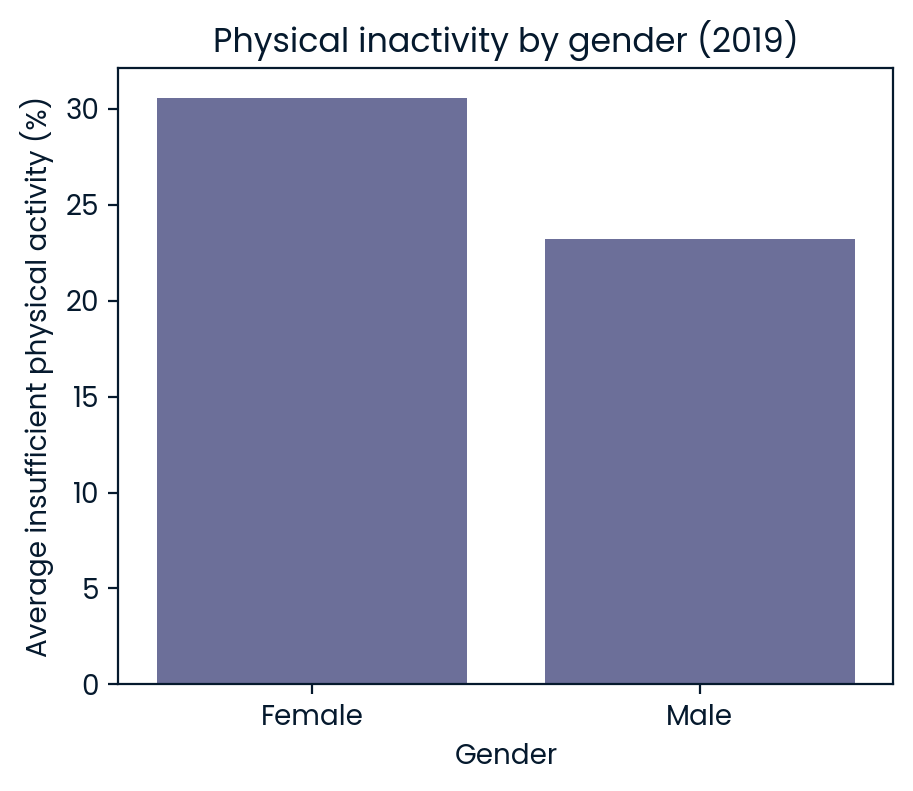

In [44]:
plt.figure(figsize=(5,4))
sns.barplot(
    data=df_gender,
    x="gender",
    y="avg_insufficient_activity"
)
plt.xlabel("Gender")
plt.ylabel("Average insufficient physical activity (%)")
plt.title("Physical inactivity by gender (2019)")
plt.show()


Результати аналізу свідчать про наявність гендерних відмінностей у рівні фізичної активності. У середньому жінки демонструють вищий рівень недостатньої фізичної активності порівняно з чоловіками, що узгоджується з результатами попередніх глобальних досліджень.

In [45]:
#Як змінювався рівень фізичної активності з часом?
df_trend = (
    df_raw[
        df_raw["Dim1"] == "Both sexes"
    ]
    .groupby("Period")["FactValueNumeric"]
    .mean()
    .reset_index()
    .rename(columns={
        "Period": "year",
        "FactValueNumeric": "avg_insufficient_activity"
    })
)

df_trend.head()


,year,avg_insufficient_activity
0,2000,26.335026
1,2001,26.315846
2,2002,26.303231
3,2003,26.296103
4,2004,26.292872


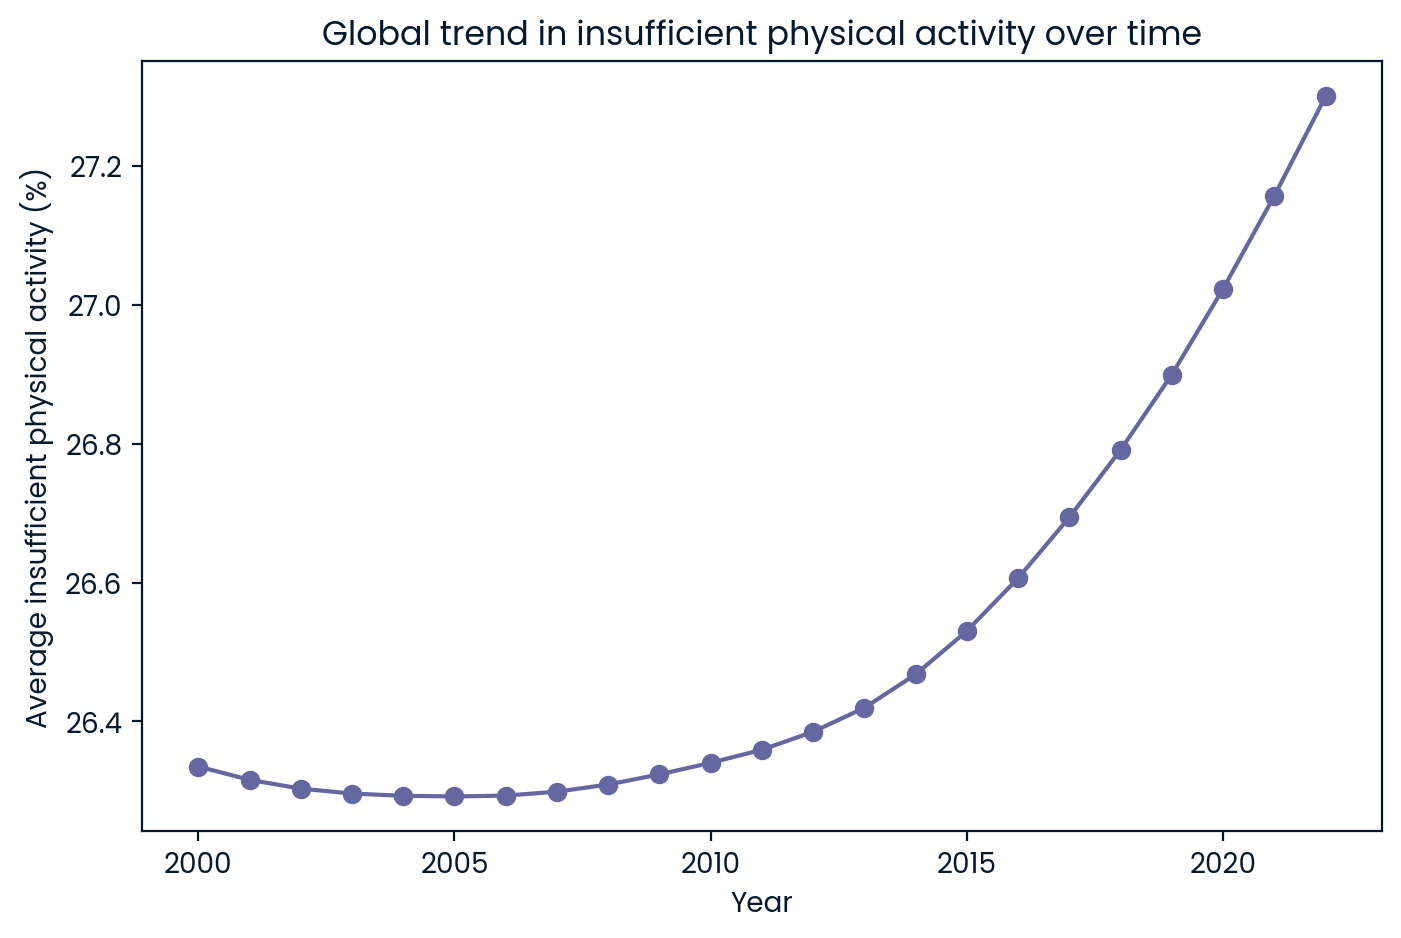

In [46]:
plt.figure(figsize=(8,5))
plt.plot(
    df_trend["year"],
    df_trend["avg_insufficient_activity"],
    marker="o"
)
plt.xlabel("Year")
plt.ylabel("Average insufficient physical activity (%)")
plt.title("Global trend in insufficient physical activity over time")
plt.show()


Аналіз динаміки показав поступову зміну рівня фізичної активності у світі з часом. Спостерігається загальна тенденція до зростання недостатньої фізичної активності, що може бути пов’язано з урбанізацією, технологічним розвитком та змінами способу життя.

In [37]:
df["sufficient_activity"] = 100 - df["insufficient_activity"]
df.head()

,country,insufficient_activity,sufficient_activity
1755,Bhutan,9.95,90.05
1760,Netherlands (Kingdom of the),10.52,89.48
1761,Sweden,10.58,89.42
1766,Finland,11.21,88.79
1768,Republic of Moldova,11.29,88.71


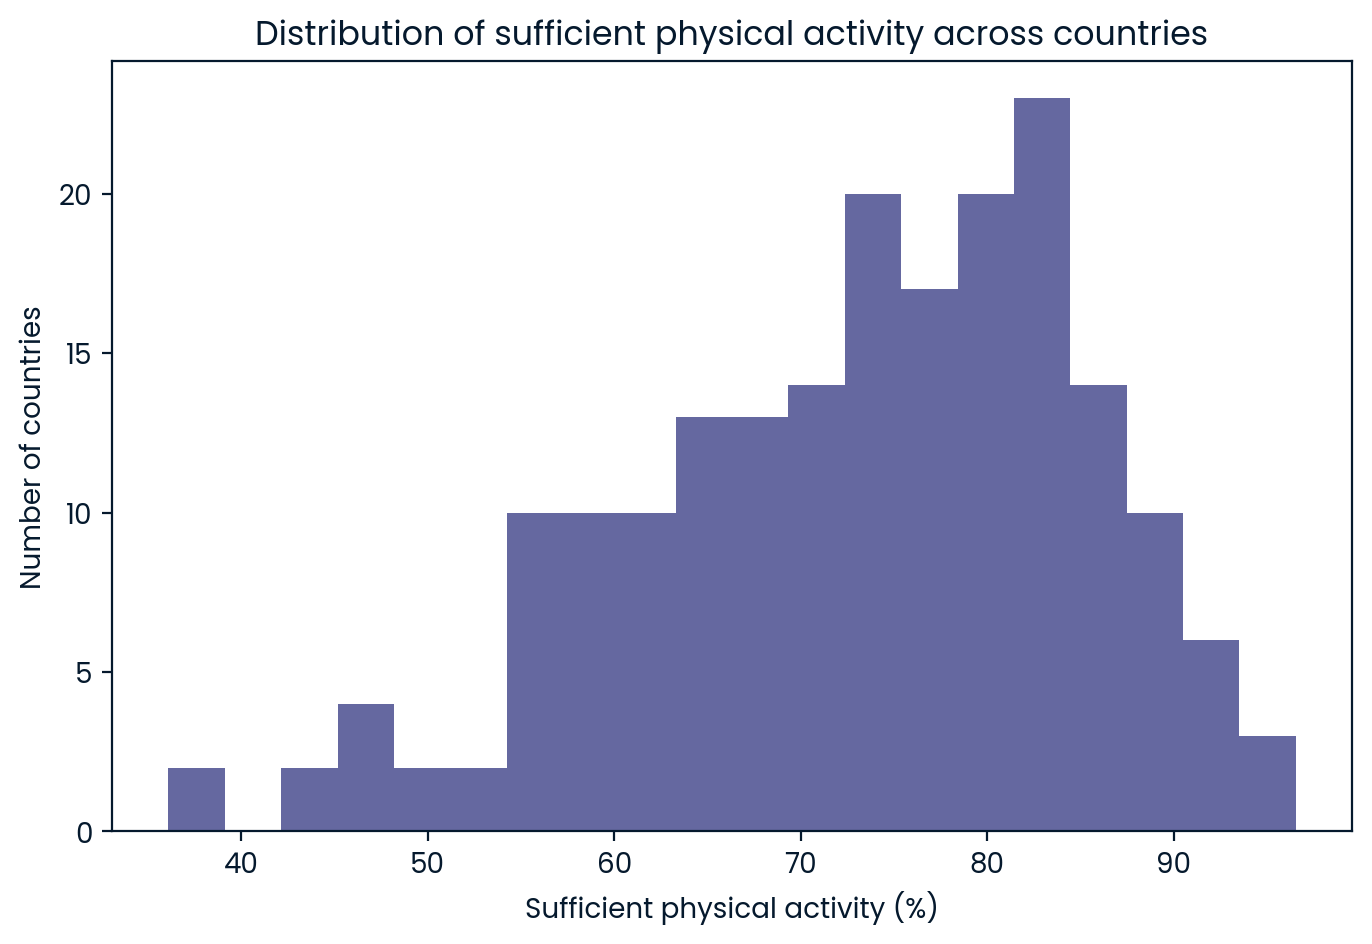

In [38]:
plt.figure(figsize=(8,5))
plt.hist(df["sufficient_activity"], bins=20)
plt.xlabel("Sufficient physical activity (%)")
plt.ylabel("Number of countries")
plt.title("Distribution of sufficient physical activity across countries")
plt.show()



Гістограма показує, що більшість країн мають відносно високий рівень достатньої фізичної активності (понад 60%), однак розподіл є асиметричним. Спостерігається група країн з суттєво нижчим рівнем фізичної активності, що свідчить про значні глобальні відмінності та потенційні ризики для здоровʼя населення в окремих регіонах.

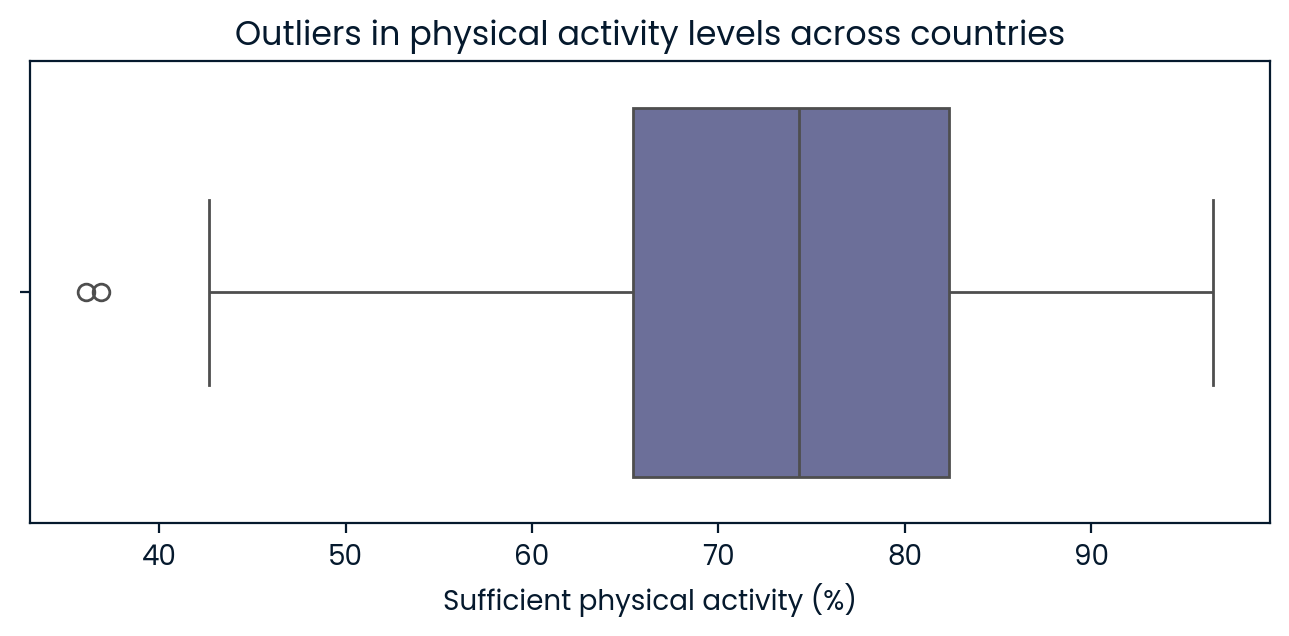

In [39]:
plt.figure(figsize=(8,3))
sns.boxplot(x=df["sufficient_activity"])
plt.xlabel("Sufficient physical activity (%)")
plt.title("Outliers in physical activity levels across countries")
plt.show()



Boxplot показує, що хоча між країнами існує значна варіативність рівня фізичної активності, більшість значень лежить у відносно компактному діапазоні. Формальних статистичних аутлайєрів небагато, що свідчить про відсутність крайніх екстремальних значень та відносну однорідність глобального розподілу.

In [40]:
df.sort_values("sufficient_activity").head(10)
df.sort_values("sufficient_activity", ascending=False).head(10)


,country,insufficient_activity,sufficient_activity
2094,Malawi,3.45,96.55
2272,United Republic of Tanzania,4.97,95.03
2275,Uganda,5.91,94.09
2318,Vanuatu,7.98,92.02
2317,Niue,7.98,92.02
2319,Lesotho,8.20,91.80
2321,Nepal,8.45,91.55
2328,Mozambique,9.05,90.95
2329,Kenya,9.25,90.75
2336,Ethiopia,9.75,90.25


Високий рівень фізичної активності в окремих країнах може бути пов’язаний зі способом життя, де фізична праця та активне пересування є необхідністю, а не свідомим вибором.

Кластеризація дозволила виділити три групи країн із низьким, середнім та високим рівнем фізичної активності. Країни з найвищою активністю формують окремий кластер, що підтверджує наявність глобальних патернів фізичної активності.